### PUI2016_jz2575 Homework 6:
https://github.com/fedhere/PUI2016_fb55/blob/master/HW6_fb55/building_nrg_instructions.ipynb


In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import matplotlib
import os
import json
import urllib2
import sys
import seaborn
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('ggplot')

#s = json.load( open(os.getenv('PUI2016') +'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)

%pylab inline

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY 
https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

### IDEA:  
How well does the number of units in the building determine the energy consumed?

### Null Hypothesis:  
The measure of energy consumed in the building does not relate to the number of units in the building, statistical significance at p = 0.05.

### Alternate Hypothesis:  
The measure of energy consumed in the building increases proportionally to the number of units in the building, statistical significance at p = 0.05.


    

In [2]:
os.getenv('PUIDATA')

'/home/cusp/jz2575/PUIdata'

In [3]:
# Option 1: Use pandas with json file
import datetime
from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict
query = ("https://data.cityofnewyork.us/resource/m46j-75iy.json")
raw_data = pd.read_json(query)
raw_data.head()

,automatic_water_benchmarking_eligible,bbls_co_reported,borough,co_reported_bbl_status,direct_ghg_emissions_mtco2e,dof_benchmarking_submission_status,dof_number_of_buildings,dof_property_floor_area_buildngs_and_parking_ft2,energy_star_score,indirect_ghg_emissions_mtco2e,...,reported_property_floor_area_building_s_ft,reported_water_method,site_eui_kbtu_ft2,source_eui_kbtu_ft2,street_name,street_number,total_ghg_emissions_mtco2e,weather_normalized_site_eui_kbtu_ft2,weather_normalized_source_eui_kbtu_ft2,zip_code
0,N/A,1000410001,Manhattan,NaN,NaN,BBL not valid,NaN,NaN,Not Available,NaN,...,918919,N/A,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN
1,Yes,NaN,Queens,NaN,NaN,No Submission Matched to BBL,1.0,82730.0,NaN,NaN,...,#N/A,None,NaN,NaN,108 STREET,63-10,NaN,NaN,NaN,11375.0
2,N/A,2027620097,Bronx,NaN,NaN,BBL not valid,NaN,NaN,Not Available,NaN,...,64200,N/A,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN
3,No,NaN,Manhattan,NaN,NaN,No Submission Matched to BBL,1.0,440360.0,NaN,NaN,...,#N/A,None,NaN,NaN,11 AVENUE,201,NaN,NaN,NaN,10001.0
4,N/A,2048300034,Bronx,NaN,NaN,Not on Covered Buildings List,NaN,NaN,Not Available,NaN,...,50000,None,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN


In [4]:
raw_data.columns

Index([u'automatic_water_benchmarking_eligible', u'bbls_co_reported',
       u'borough', u'co_reported_bbl_status', u'direct_ghg_emissions_mtco2e',
       u'dof_benchmarking_submission_status', u'dof_number_of_buildings',
       u'dof_property_floor_area_buildngs_and_parking_ft2',
       u'energy_star_score', u'indirect_ghg_emissions_mtco2e',
       u'municipally_supplied_potable_water_indoor_intensity_gal_ft',
       u'nyc_borough_block_and_lot_bbl',
       u'primary_property_type_self_selected', u'record_number',
       u'reported_nyc_building_identificaiton_numbers_bins',
       u'reported_property_floor_area_building_s_ft', u'reported_water_method',
       u'site_eui_kbtu_ft2', u'source_eui_kbtu_ft2', u'street_name',
       u'street_number', u'total_ghg_emissions_mtco2e',
       u'weather_normalized_site_eui_kbtu_ft2',
       u'weather_normalized_source_eui_kbtu_ft2', u'zip_code'],
      dtype='object')

In [5]:
# OPTION 2: Load CSV
!curl -O 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv'
#move to PUIDATA

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3110k    0 3110k    0     0  9984k      0 --:--:-- --:--:-- --:--:-- 21.2M


In [6]:
os.system("mv " + "rows.csv " + os.getenv("PUIDATA"))

0

In [7]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/rows.csv")
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

In [8]:
nrg.head()

,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,NaN,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,NaN,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,NaN,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [9]:
!curl -O 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.6M  100 11.6M    0     0  31.4M      0 --:--:-- --:--:-- --:--:-- 48.0M


In [10]:
os.system("mkdir " + os.getenv("PUIDATA") + "/mn_mappluto_16v1")

256

In [11]:
os.system("mv " + "mn_mappluto_16v1.zip " + os.getenv("PUIDATA"))

0

In [12]:
os.system("unzip " + os.getenv("PUIDATA") + 
          "/mn_mappluto_16v1.zip -d " + os.getenv("PUIDATA") + 
          "/mn_mappluto_16v1")

256

In [13]:
os.system("rm " + os.getenv("PUIDATA") + "/mn_mappluto_16v1.zip")

0

In [14]:
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                  "/mn_mappluto_16v1/MNMapPLUTO.shp")

In [15]:
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

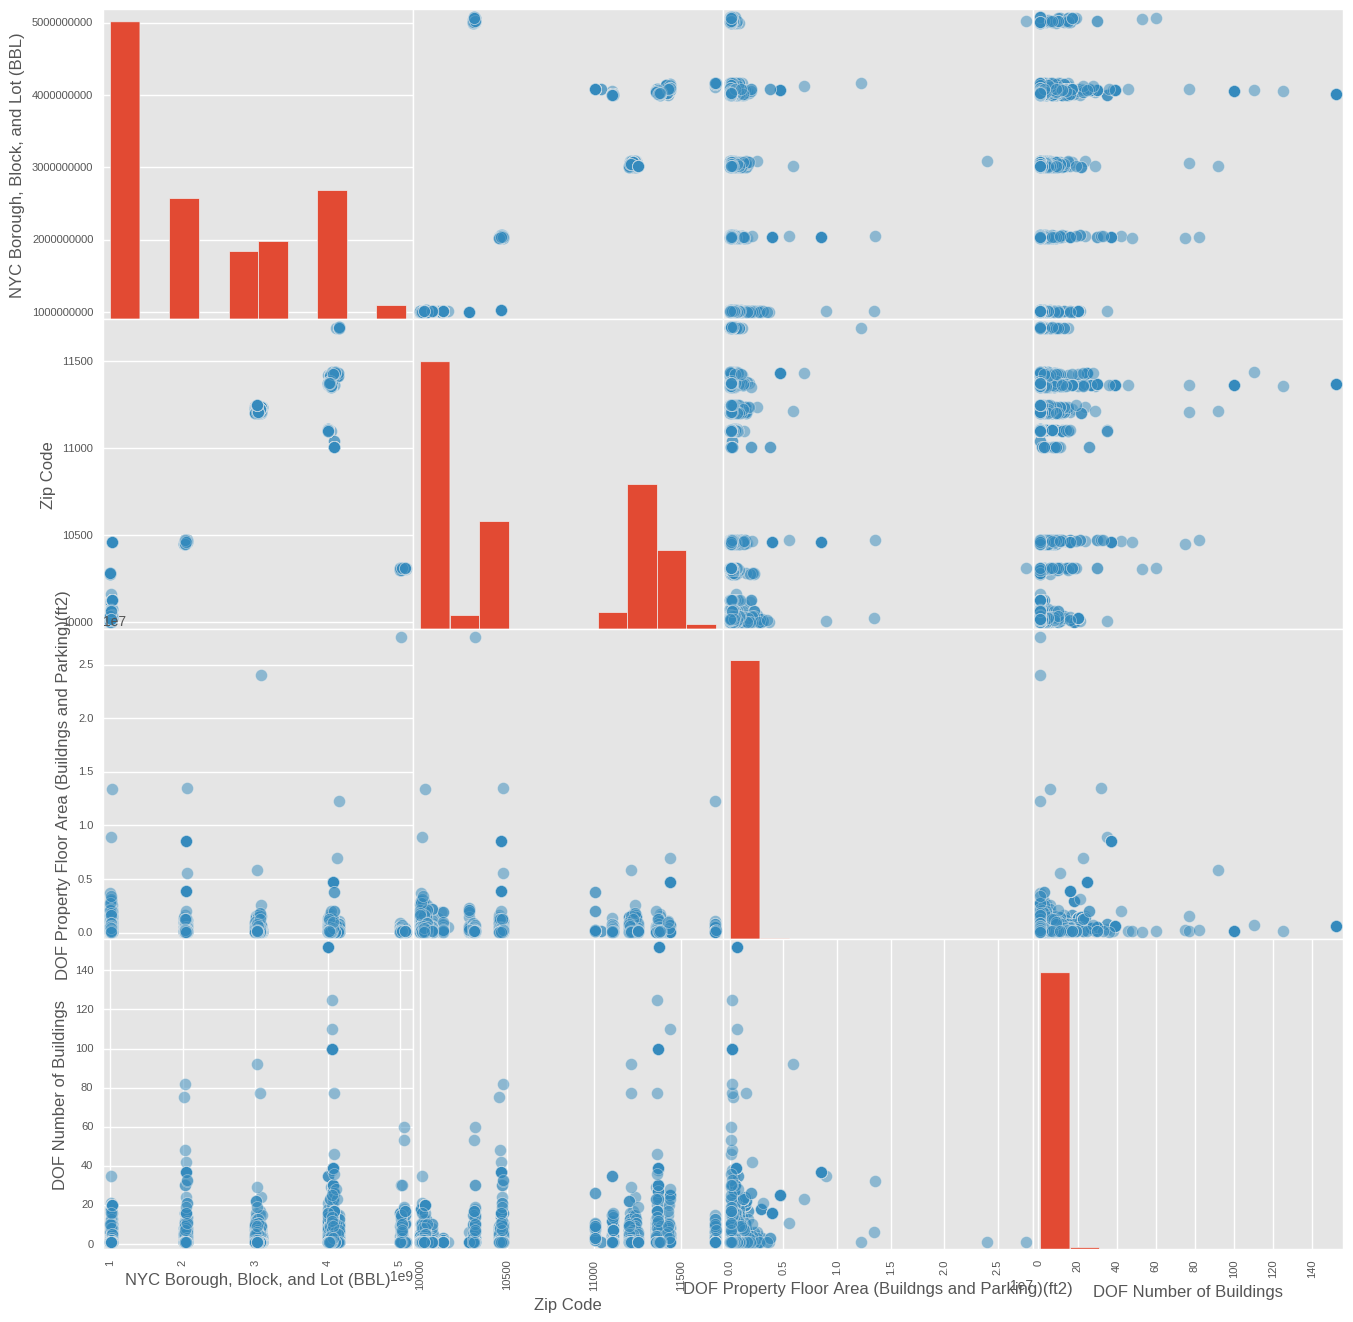

In [16]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(nrg, s=300, figsize=(16, 16))
pl.show()

## Figure 1: scatter matrix of Building Information

In [17]:
nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)':'BBL'}, inplace=True)

In [18]:
nrg.rename(columns={'Site EUI(kBtu/ft2)':'ECA'}, inplace=True) # ECA = Energy consumption based on area

In [19]:
nrg.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'BA'}, inplace=True) # BA = Area of Building

In [20]:
nrg1 = nrg[['BBL', 'ECA', 'BA']]

In [21]:
nrg1['ECA'] = pd.to_numeric(nrg1['ECA'], errors='coerce')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
nrg1['BA'] = pd.to_numeric(nrg1['BA'], errors='coerce')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:1237: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


In [24]:
bsize = bsize[['BBL','BldgArea','SanitBoro','SanitDist','SanitSub',\
            'UnitsRes','UnitsTotal','YearBuilt','ZipCode','geometry']]

In [25]:
#nrg1['BBL'] = nrg1['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(nrg1, bsize, how = 'inner', on = 'BBL')

In [26]:
bblnrgdata.head()

,BBL,ECA,BA,BldgArea,SanitBoro,SanitDist,SanitSub,UnitsRes,UnitsTotal,YearBuilt,ZipCode,geometry
0,1.006700e+09,NaN,NaN,440360,1,04,2B,0,1,1987,10001,"POLYGON ((982544.9469999969 212642.9668000042,..."
1,1.004370e+09,NaN,NaN,52390,1,03,4B,0,4,1920,10009,"POLYGON ((988632.9397999942 204610.9329999983,..."
2,1.013110e+09,125.4,330000.0,313200,1,06,3B,0,56,1977,10022,"POLYGON ((993141.1744000018 216172.3948000073,..."
3,1.009220e+09,NaN,NaN,98260,1,06,1A,148,148,1963,10003,"POLYGON ((989369.5851999968 206338.7575999945,..."
4,1.007400e+09,NaN,68329.0,48800,1,04,1A,0,1,1920,10011,"POLYGON ((983418.6007999927 209632.8701999933,..."


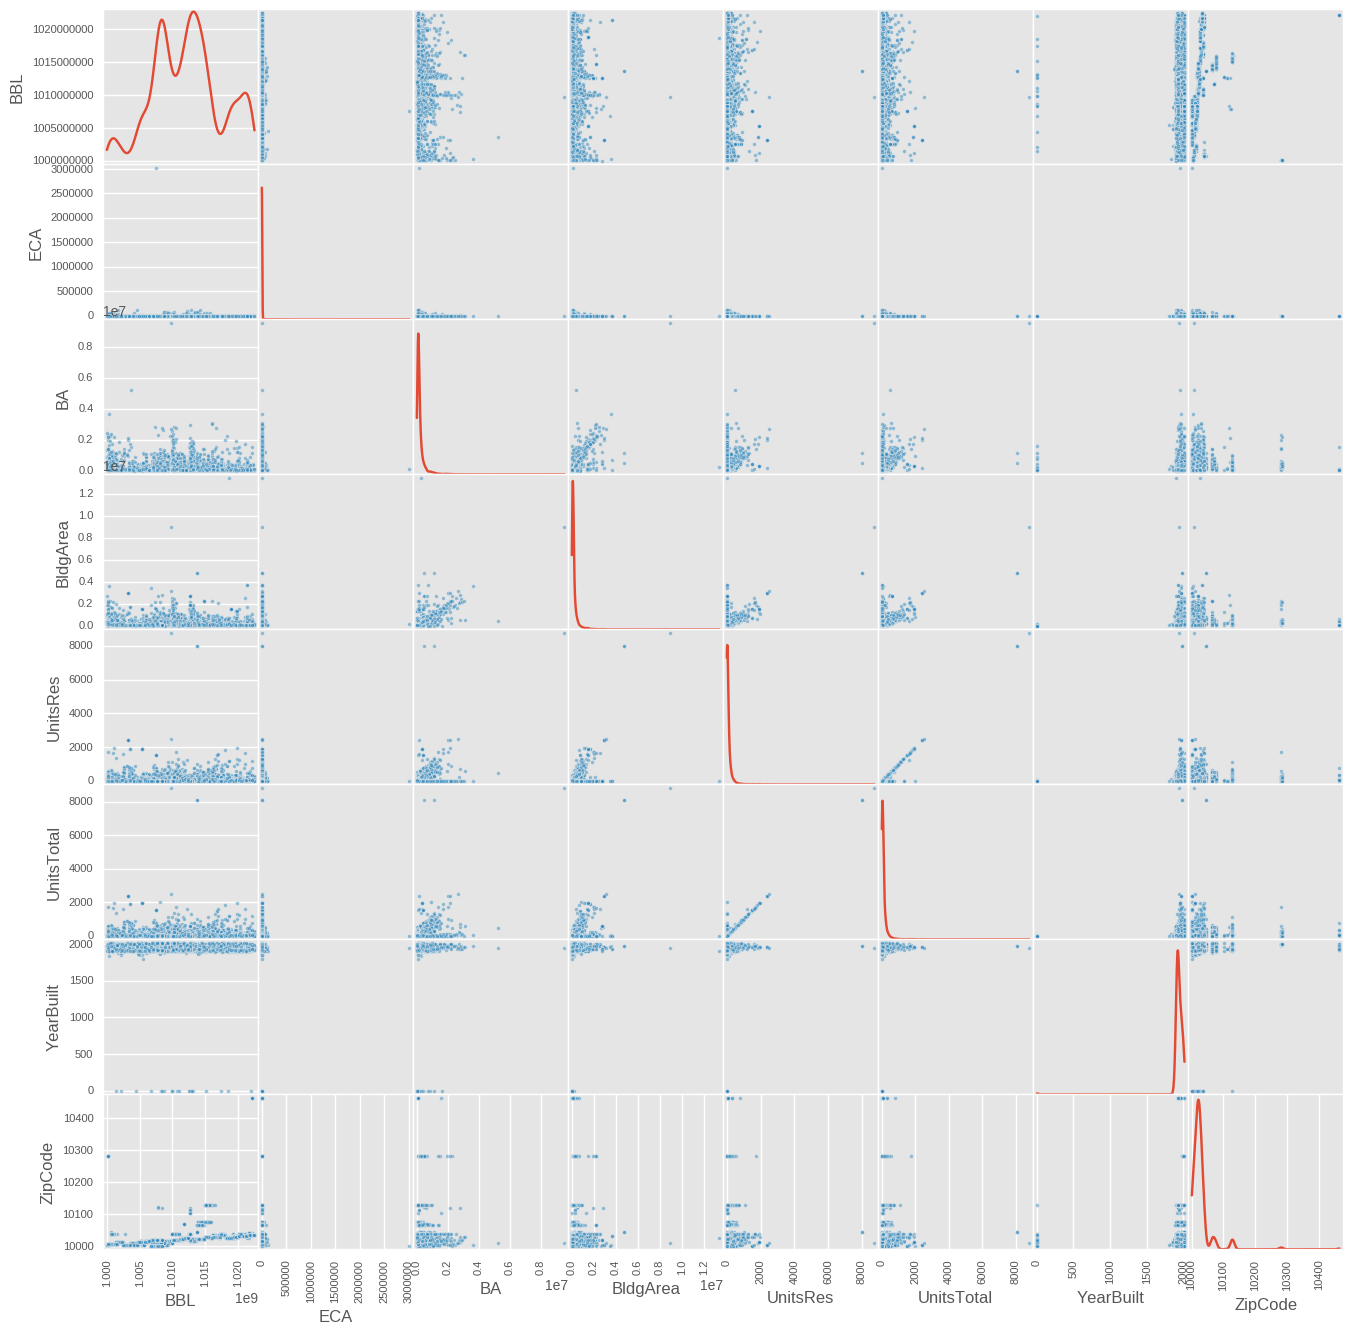

In [27]:
scatter_matrix(bblnrgdata, s = 30, figsize = (16,16), diagonal='kde')
pl.show()

### Figure 2: Scatter Matrix of Merged Building Information and Manhattan Pluto Mapping Information

In [28]:
bblnrgdata['Total Energy'] = bblnrgdata['ECA'] * bblnrgdata['BA']

In [29]:
bblnrgdata.head()

,BBL,ECA,BA,BldgArea,SanitBoro,SanitDist,SanitSub,UnitsRes,UnitsTotal,YearBuilt,ZipCode,geometry,Total Energy
0,1.006700e+09,NaN,NaN,440360,1,04,2B,0,1,1987,10001,"POLYGON ((982544.9469999969 212642.9668000042,...",NaN
1,1.004370e+09,NaN,NaN,52390,1,03,4B,0,4,1920,10009,"POLYGON ((988632.9397999942 204610.9329999983,...",NaN
2,1.013110e+09,125.4,330000.0,313200,1,06,3B,0,56,1977,10022,"POLYGON ((993141.1744000018 216172.3948000073,...",41382000.0
3,1.009220e+09,NaN,NaN,98260,1,06,1A,148,148,1963,10003,"POLYGON ((989369.5851999968 206338.7575999945,...",NaN
4,1.007400e+09,NaN,68329.0,48800,1,04,1A,0,1,1920,10011,"POLYGON ((983418.6007999927 209632.8701999933,...",NaN


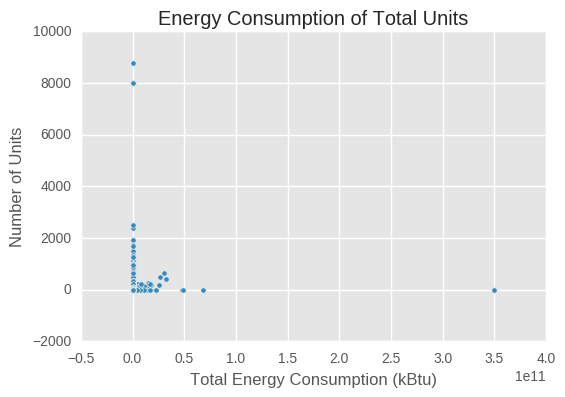

In [30]:
bblnrgdata.plot.scatter(x='Total Energy', y='UnitsRes', s=15)
pl.xlabel('Total Energy Consumption (kBtu)')
pl.ylabel('Number of Units')
pl.title('Energy Consumption of Total Units')

## Figure 3: Total Energy Consumption of Total Units in Manhattan buildings

(1, 1000)

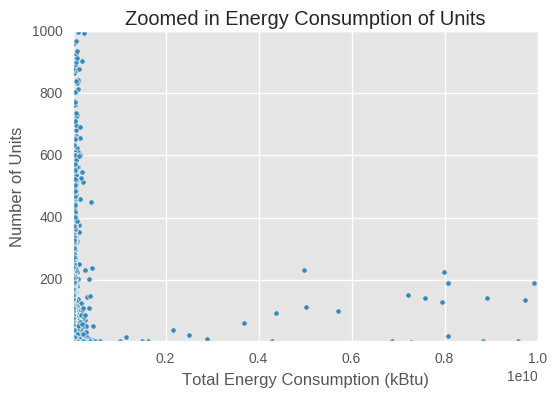

In [31]:
bblnrgdata.plot.scatter(x='Total Energy', y='UnitsTotal', s=15)
pl.xlabel('Total Energy Consumption (kBtu)')
pl.ylabel('Number of Units')
pl.title('Zoomed in Energy Consumption of Units')
pl.xlim(1000, 1e10)
pl.ylim(1,1000)

### Figure 4:  Total Energy Consumption of Total Units in Manhattan buildings(Zoomed in) 

In [32]:
#Remove Outliers
bblnrgdata_cut = bblnrgdata[bblnrgdata['Total Energy'] > 1000]
bblnrgdata_cut = bblnrgdata_cut[bblnrgdata_cut['UnitsTotal'] >= 10]

(10, 1000)

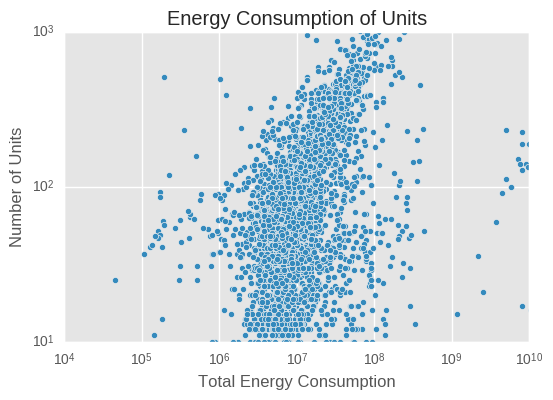

In [33]:
bblnrgdata_cut.plot.scatter(x='Total Energy', y='UnitsTotal', loglog=True)
pl.xlabel('Total Energy Consumption')
pl.ylabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.xlim(1e4, 1e10)
pl.ylim(10, 1000)

(10, 1000)

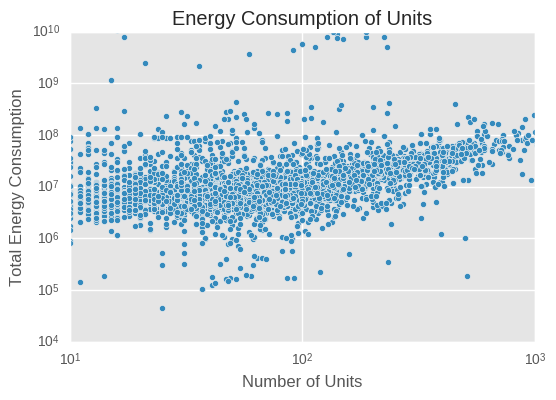

In [34]:
bblnrgdata_cut.plot.scatter(x='UnitsTotal', y='Total Energy', loglog=True)
pl.ylabel('Total Energy Consumption')
pl.xlabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.ylim(1e4, 1e10)
pl.xlim(10, 1000)

when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

if you used statsmodels it would look something like this:

Chi-square Energy vs Unit is 1027.00547962: 


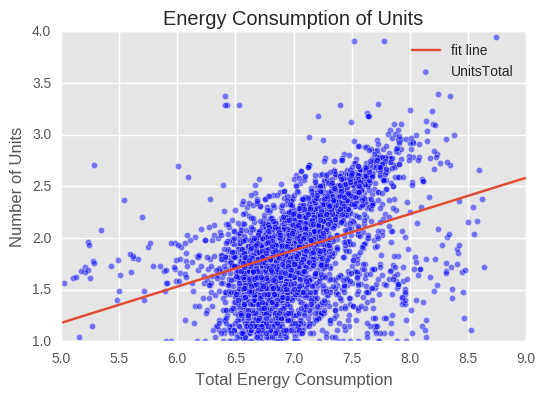

In [35]:
x = bblnrgdata_cut['Total Energy']
y = bblnrgdata_cut['UnitsTotal']
X = sm.add_constant(np.log10(x))
model= sm.OLS(np.log10(y), X, missing='drop').fit()
model_Y = model.predict()
observed_y = np.log10(y)
error = observed_y / 2
chisq = ((model_Y - observed_y)**2 / (error**2)).sum()
print ("Chi-square Energy vs Unit is %s: " %chisq)
pl.scatter(log10(x), log10(y), alpha=0.5)
x_fit = np.linspace(5, 10, 1000)
X_fit = sm.add_constant(x_fit)
plot(x_fit, model.predict(X_fit), label='fit line')

pl.xlabel('Total Energy Consumption')
pl.ylabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.ylim(1, 4)
pl.xlim(5,9)
pl.legend(loc='best')

In [36]:
DOF = len(bblnrgdata_cut) - 2 - 1 # DOF = degree of freedom
print ("Goodness of fit for Chi-square: ", chisq / DOF)

Goodness of fit for Chi-square:  0.239005231469


In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     885.3
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          4.59e-177
Time:                        08:15:18   Log-Likelihood:                -1896.2
No. Observations:                4300   AIC:                             3796.
Df Residuals:                    4298   BIC:                             3809.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.5774      0.083     -6.938      0.000        -0.741    -0.414
Total Energy     0.3512      0.012     29.755      0.000         0.328     0.374
==============================================================================
Omnibus:                      122.404   Durbin-Watson:                   1.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.412
Skew:                          -0.277   Prob(JB):                     7.41e-42
Kurtosis:                       3.866   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
y = bblnrgdata_cut['Total Energy']
x = bblnrgdata_cut['UnitsTotal']

In [39]:
X = sm.add_constant(np.log10(x))
model= sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires where x or y is NaN

In [40]:
model_Y = model.predict()
observed_y = np.log10(y)
error = observed_y / 2
chisq = ((model_Y - observed_y)**2 / (error**2)).sum()
print ("Chi-square Energy vs Unit is %s: " %chisq)

Chi-square Energy vs Unit is 62.7235141958: 


In [41]:
DOF = len(bblnrgdata_cut) - 2 - 1 # DOF = degree of freedom
print ("Goodness of fit for Chi-square: ", chisq / DOF)

Goodness of fit for Chi-square:  0.0145970477533


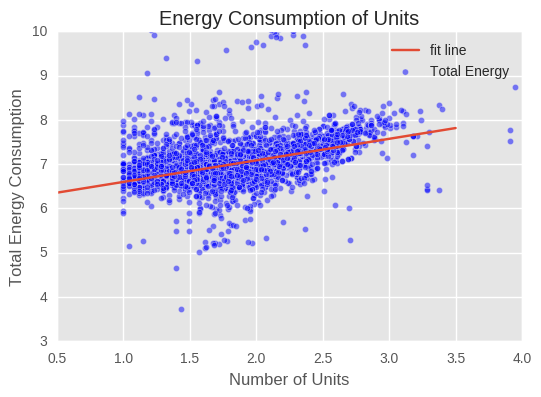

In [42]:
pl.scatter(log10(x), log10(y), alpha=0.5)
x_fit = np.linspace(0.5, 3.5, 1000)
X_fit = sm.add_constant(x_fit)
plot(x_fit, model.predict(X_fit), label='fit line')

pl.ylabel('Total Energy Consumption')
pl.xlabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.xlim(0.5, 4)
pl.ylim(3,10)
pl.legend(loc='best')

In [43]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Total Energy   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     885.3
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          4.59e-177
Time:                        08:15:28   Log-Likelihood:                -2596.6
No. Observations:                4300   AIC:                             5197.
Df Residuals:                    4298   BIC:                             5210.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1138      0.032    193.043      0.000         6.052     6.176
UnitsTotal     0.4864      0.016     29.755      0.000         0.454     0.518
==============================================================================
Omnibus:                     2234.497   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43560.641
Skew:                           2.033   Prob(JB):                         0.00
Kurtosis:                      18.053   Cond. No.                         11.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### the goodness of fit of chi-square test tells the units vs energy is better 

In [44]:
polyfit = pd.DataFrame()
polyfit['X'] = np.log10(bblnrgdata_cut['UnitsTotal'])
polyfit['Y'] = np.log10(bblnrgdata_cut['Total Energy'])
polyfit['X2'] = np.log10(bblnrgdata_cut['UnitsTotal'])**2

In [45]:
polyfit.head()

,X,Y,X2
2,1.748188,7.616811,3.056161
16,1.380211,7.629287,1.904983
18,1.380211,7.286094,1.904983
19,1.792392,6.950549,3.212668
20,1.929419,6.811909,3.722657


In [46]:
poly2 = smf.ols(formula = 'Y ~ X2 + X', data=polyfit).fit()

In [47]:
poly2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     566.8
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          3.53e-219
Time:                        08:15:34   Log-Likelihood:                -2496.0
No. Observations:                4300   AIC:                             4998.
Df Residuals:                    4297   BIC:                             5017.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.4441      0.098     76.179      0.000         7.252     7.636
X2             0.3658      0.025     14.352      0.000         0.316     0.416
X             -0.9418      0.101     -9.344      0.000        -1.139    -0.744
==============================================================================
Omnibus:                     2274.437   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54059.589
Skew:                           2.018   Prob(JB):                         0.00
Kurtosis:                      19.895   Cond. No.                         99.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
polyfit2 = polyfit[['X2', 'X']]

In [49]:
polyfit2.head()

,X2,X
2,3.056161,1.748188
16,1.904983,1.380211
18,1.904983,1.380211
19,3.212668,1.792392
20,3.722657,1.929419


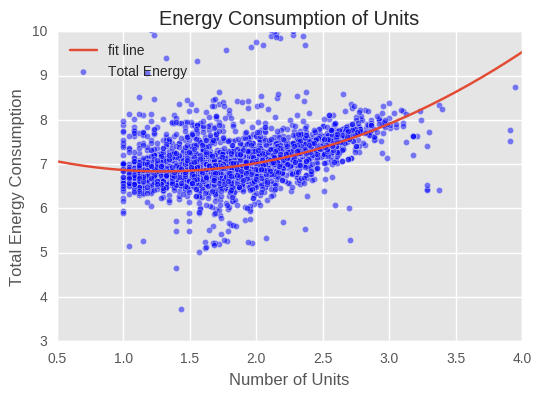

In [50]:
pl.scatter(log10(x), log10(y), alpha=0.5)
polyfit2 = pd.DataFrame()
polyfit2['X'] = np.arange(0.5, 4.5, 0.1)
polyfit2['X2'] = polyfit2['X']**2
plot(polyfit2['X'], poly2.predict(polyfit2), label='fit line')

pl.ylabel('Total Energy Consumption')
pl.xlabel('Number of Units')
pl.title('Energy Consumption of Units')
pl.xlim(0.5, 4)
pl.ylim(3,10)
pl.legend(loc='best')

remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

##now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

In [51]:
print ("LR : ", -2 * (model.llf - poly2.llf))

LR :  201.323651815


In [52]:
print ("LR from statsmodels:", poly2.compare_lr_test(model))

LR from statsmodels: (201.32365181516525, 1.0739550136372629e-45, 1.0)


for degree of freedom 1 and significance level 0.05, critical value is 3.84.  LR is larger than 3.84, therefore we can reject null hypothesis that linear model is better fit for data than polynomial 2nd degree model

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [146]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    




In [ ]:
bblnrgdatacut['YearBuilt'][bblnrgdatacut['YearBuilt']<1800]=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)